# Predicting COVID-19 Deaths by Similarity

I have been seen some discussion about epidemiologic models to predict the number of cases and deaths by COVID-19, which made me give some thought about the subject.

Since we have countries in different stages of the pandemic, my hypothesis was that we could use information from countries in advanced stages to predict information for countries at the beginning of the crisis.

Considering the number of deaths by COVID-19 registered, we can align the data for all countries, such that the day the first death by COVID-19 was registered for each country coincides with the origin.

With the data shifted, we can compute the correlation between each pair of countries and then find those pairs with high correlation. We can fit a linear regression to each of these pairs considering the country with more data as the independent variable and the one with fewer data as the response variable.

We can then use the data for the country with more data to predict the number of deaths for the other country. For, instance, for Brazil, the 8 highest correlated countries are Canada, USA, Egypt, Japan, Argentina, UK, Italy and Iran (all of them with correlation > 0.95).

I used the data provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) in their [GitHub repository](https://github.com/CSSEGISandData/COVID-19).

The code for this notebook can be downloaded from [here](https://github.com/luizvbo/notebooks/blob/master/covid_linear_reg.py).

In [10]:
from typing import Tuple, Dict
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from functools import partial
from glob import glob
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [11]:
# URL to the CSSE repository
url_covid_death = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/"
                   "master/csse_covid_19_data/csse_covid_19_time_series/"
                   "time_series_covid19_deaths_global.csv")
# URL to the population data from Worldbank
url_pop = ("http://api.worldbank.org/v2/en/indicator/"
           "SP.POP.TOTL?downloadformat=csv")

In [12]:
def get_same_origin(df: pd.DataFrame) -> pd.DataFrame:
    """Move first case to the origing

    Args:
        df (pd.DataFrame): Input data frame, where each column corresponds to
        one country. It should be the output of the function `set_index`.

    Returns:
        pd.DataFrame: Data frame with every column shifted up
    """
    n_days = df.shape[0]

    def _pad_days(s):
        s = s.astype(float)
        s_pad = s[s.cumsum() != 0]
        return np.pad(s_pad, (0, n_days-s_pad.shape[0]),
                      'constant', constant_values=np.nan)

    df = (
        df.apply(_pad_days, raw=True)
        .reset_index(drop=True)
    ).dropna(how='all')

    return df


def set_index(df: pd.DataFrame) -> pd.DataFrame:
    """Set the index for the data frame using the date

    Args:
        df (pd.DataFrame): Data frame obtained from John Hopkins repo

    Returns:
        pd.DataFrame: Preprocessed data
    """
    # Set region, country, lat and long as index
    index = pd.MultiIndex.from_frame(df.iloc[:, :4])
    # Set the index and transpose
    df = df.iloc[:, 4:].set_index(index).T
    # Set date as index
    return df.set_index(pd.to_datetime(df.index, dayfirst=False))


def compute_lr(country: Tuple[int, str], df_covid: pd.DataFrame,
               min_diff: int = 7) -> Dict[Tuple[str, str], Dict]:
    """Fit the logistic regression for each pair of countries

    Args:
        country (Tuple[int, str]): Tuple with the index of the
            country in the column list and the country
        df_covid (pd.DataFrame): Data frame containing the data shifted to
            the origin.
        min_diff (int, optional): Minimum difference in the number of days to
            consider the country pair. Defaults to 7.

    Returns:
        Dict[Tuple[str, str], Dict]: Dictionary where the keys are the pairs
            of countries and the value is a data dictionary with the data
            computued.
    """
    i, col_1 = country
    results = {}

    for col_2 in df_covid.columns[i+1:]:

        x = df_covid[col_1].dropna().values
        y = df_covid[col_2].dropna().values

        # Keep the largest array in x
        if x.shape[0] < y.shape[0]:
            x, y = y, x
            x_label, y_label = col_2, col_1
        else:
            x_label, y_label = col_1, col_2

        x, y = x.reshape(-1, 1), y.reshape(-1, 1)

        if x.shape[0] - y.shape[0] > min_diff:
            lr = LinearRegression()
            # The weights increase linearly from 1 to 2
            weights = np.linspace(1, 1, y.shape[0])
            lr.fit(x[:y.shape[0]], y, weights)

            results[(x_label, y_label)] = dict(
                lr_model=lr,
                r_score=lr.score(x[:y.shape[0]], y),
                predicted=lr.predict(x),
                x=x, y=y,
            )

    return results


def plot_candidates(df_candidates: pd.DataFrame,
                    nrows: int = 4, ncols: int = 2,
                    over_days: bool = True,
                    figsize: Tuple[int, int] = (12, 15)):
    """Plot the regression for pairs of countries

    Args:
        df_candidates (pd.DataFrame): Data frame with pairs of countries with
            the linear regression data

        nrows (int, optional): Number of rows to plot. Defaults to 4.
        ncols (int, optional): NBumber of columns to plot. Defaults to 2.
        over_days (bool, optional): If True, plot the data over days.
            Otherwise, plot one country agains the other. Defaults to True.
        figsize (Tuple[int, int], optional): Size of the resulting fiture.
            Defaults to (12, 15).

    Returns:
        [type]: Figure object
    """
    fig, axs = plt.subplots(nrows, ncols)
    df_ = df_candidates.head(nrows * ncols)
    for (i, row), ax in zip(df_.iterrows(), axs.flatten()):
        if over_days:
            ax.plot(row['x'], label=i[0])
            ax.plot(row['y'], label=i[1])
            ax.plot(row['predicted'], '--', label=f"{i[1]} (predicted)")
            ax.set_xlabel("Days since the first death by COVID-19")
            ax.set_ylabel("Number of deaths")
        else:
            ax.plot(row['x'][:row['y'].shape[0]], row['y'], label='True value')
            ax.plot(row['x'], row['predicted'], '--', label='Predicted')
            ax.set_xlabel(i[0])
            ax.set_ylabel(i[1])

        ax.grid(True)
        ax.legend(title="$r^2={:.3f}$".format(row['r_score']),
                  loc='upper left')

    fig.set_size_inches(*figsize)
    return fig

In [13]:
# Getting the population information
!wget {url_pop} -O pop.zip
!unzip -o pop.zip -d pop_csv
# Load the population file
df_pop_ = pd.read_csv(glob('pop_csv/API_SP.POP.TOTL*.csv')[0],  skiprows=4)
df_pop = df_pop_[['Country Name', '2018']].set_index('Country Name')
# Delete the files downloaded
!rm -r pop_csv

--2020-05-11 22:03:17--  http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
Resolving api.worldbank.org (api.worldbank.org)... 34.237.118.134
Connecting to api.worldbank.org (api.worldbank.org)|34.237.118.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78803 (77K) [application/zip]
Saving to: ‘pop.zip’

pop.zip             100%[===================>]  76.96K   152KB/s    in 0.5s    

2020-05-11 22:03:19 (152 KB/s) - ‘pop.zip’ saved [78803/78803]

Archive:  pop.zip
  inflating: pop_csv/Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_988606.csv  
  inflating: pop_csv/API_SP.POP.TOTL_DS2_en_csv_v2_988606.csv  
  inflating: pop_csv/Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_988606.csv  


In [19]:
# Loading the data for the number of Deaths
df_death = pd.read_csv(url_covid_death)

df = set_index(df_death)

# Groupy territories per country
df = df.groupby(level=1, axis=1).sum()

# # Drop all-zeros columns
df = df[df.sum()[lambda s: s > 0].index]

# # Shift all series to the origin (first death)
df = get_same_origin(df)

In [20]:
# Ignore countries with less than 1M
countries = [c for c in df.columns if c not in
             df_pop[lambda df_: df_['2018'] < 10**6].index]

compute_lr_parallel = partial(compute_lr, df_covid=df[countries])

with Pool(8) as pool:
    results = {}
    for res_dict in tqdm(pool.imap(compute_lr_parallel, enumerate(countries)),
                         total=df.shape[0]):
        results.update(res_dict)
df_results = pd.DataFrame.from_dict(results, orient='index')

144it [00:02, 50.77it/s]                         


# Plots

## Linear Regression Results

The first set of figures shows the output for the linear regression, considering the number of deaths from Brazil as the response variable (y-axis) and each of the other countries as the dependent variable (x-axis). 

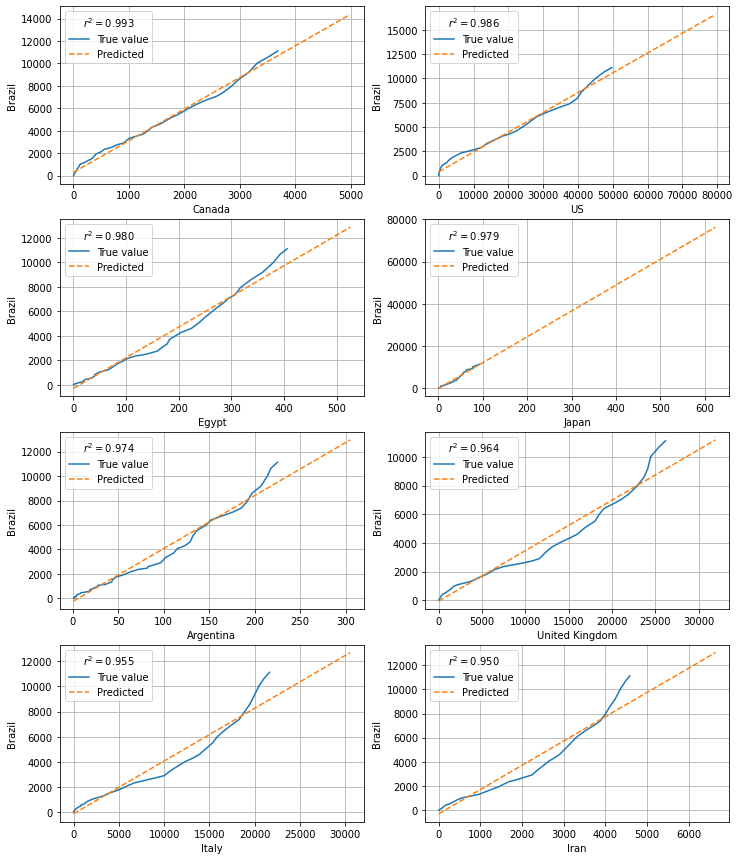

In [23]:
df_brazil = df_results[lambda df: (df.index.get_level_values(1) == 'Brazil')].sort_values('r_score', ascending=False)
fig1 = plot_candidates(df_brazil, over_days=False)

## Predictions

The second set shows the prediction, for the number of deaths in Brazil, according to the line fitted to each of the other countries. The number of days in future is limited by the data available for the other country.

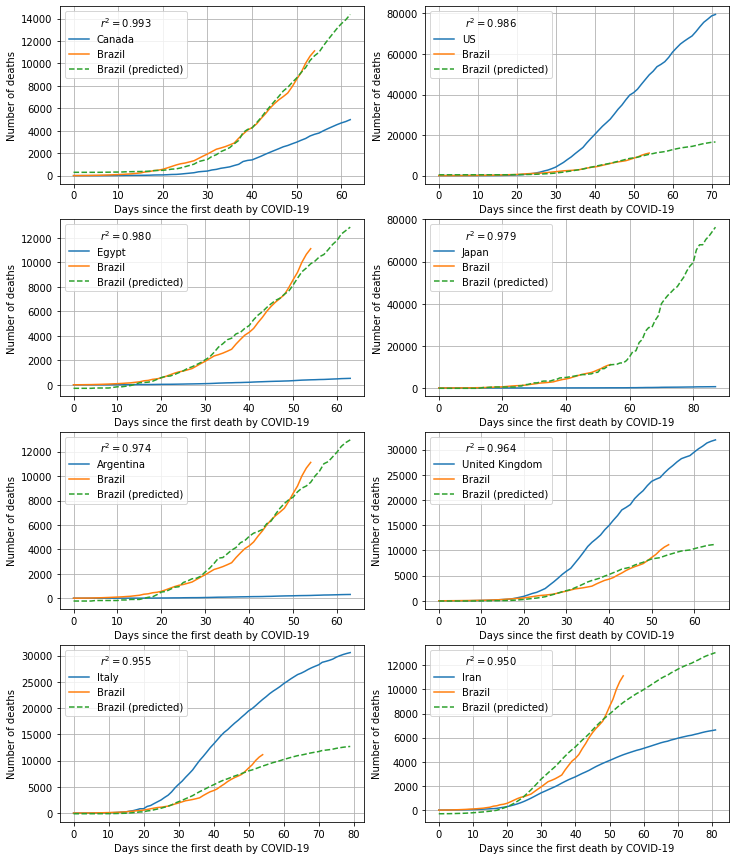

In [25]:
fig2 = plot_candidates(df_, over_days=True)